In [2]:
import os
import sys

import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import haystack as hs
from haystack.modeling.evaluation.squad import compute_f1, compute_exact
import torch
import transformers as tfm

sys.path.append("../src/")

import qa

%load_ext autoreload
%autoreload 2

DOMAIN = "movies"

READER_MODEL = "deepset/minilm-uncased-squad2"
DPR_QUERY_MODEL = "facebook/dpr-question_encoder-single-nq-base"
DPR_CTX_ENCODER= "facebook/dpr-ctx_encoder-single-nq-base"

# data directory to convert to SQUAD format
TRANSFORMED_DATA_DIR = "../data/transformed/"
SQUAD_FILENAME_TEMPLATE = f"{DOMAIN}-{{split}}.json"

/Users/spayot/miniforge3/envs/tfm7/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# load dataset

In [4]:
domains = datasets.get_dataset_config_names("subjqa")
print("existing domains for subjqa:", domains, "\n")

assert DOMAIN in domains, f"{DOMAIN} this is not a valid domain name"
subjqa = datasets.load_dataset("subjqa", name=DOMAIN)
print(subjqa["train"]["answers"][1], "\n")

existing domains for subjqa: ['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor'] 



100%|██████████| 3/3 [00:00<00:00, 198.42it/s]

{'text': [], 'answer_start': [], 'answer_subj_level': [], 'ans_subj_score': [], 'is_ans_subjective': []} 



## Exploratory Data Analysis

In [5]:
dfs = {split: dataset.to_pandas() for split, dataset in subjqa.flatten().items()}

def print_slices_size(dfs: dict[str, pd.DataFrame]) -> None:
    for split, df in dfs.items():
        print(f"Number of questions in {split + ':':<15} {df['id'].nunique():>10,}")

print_slices_size(dfs)

Number of questions in train:               1,369
Number of questions in test:                  291
Number of questions in validation:            261


In [6]:
# display sample data
qa_cols = ["title", "question", "answers.text", "answers.answer_start", "context"]

sample_df = dfs["train"].loc[:,qa_cols].sample(2)

sample_df

,title,question,answers.text,answers.answer_start,context
291,6305426651,Is the color better?,[],[],"If we could all view life in the way this main character, did, LIFE WOULD BE..."
1302,B00AF6B22E,How is movie?,[This movie is gripping hardcore],[0],"This movie is gripping hardcore, shocking, scary, and very emotional. You w..."


In [7]:
# how many items have answers in the training set?
dfs["train"]["answers.text"].apply(lambda x: len(x) > 0).value_counts()

False    856
True     513
Name: answers.text, dtype: int64

In [61]:
idx = 0
start_idx = sample_df["answers.answer_start"].iloc[idx][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[idx][0])
assert sample_df["context"].iloc[idx][start_idx:end_idx] == sample_df["answers.text"].iloc[idx][0]

('Great movie for the whole family', 'Great movie for the whole family')

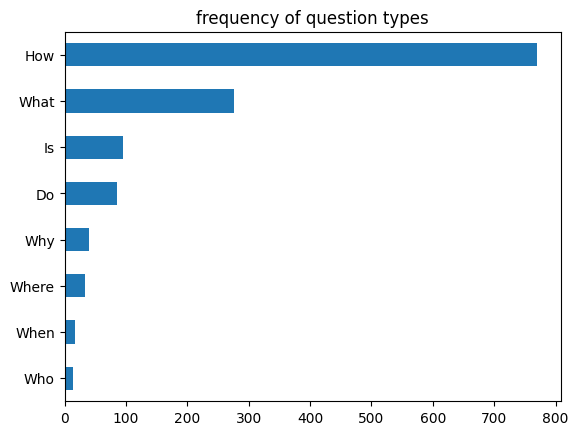

In [9]:
# refactored
# what kind of questions are in the training set?
def count_start_words(series: pd.Series, start_words: list[str]) -> dict[str,int]:
    counts = {}
    for word in start_words:
        counts[word] = (series
            .str.lower()
            .str.startswith(word.lower())
            .sum())

    return counts

def plot_word_counts(word_counts: dict[str, int]) -> None:
    (
        pd.Series(counts)
        .sort_values()
        .plot.barh(title="frequency of question types")
    );

start_words = ["How", "What", "Where", "When", "Why", "Who", "Is", "Do"]
counts = count_start_words(dfs["train"]["question"], start_words)
plot_word_counts(counts)

In [10]:
# refactored
def sample_series_with_start_word(series: pd.Series, start_word: str, sample_size: int = 3) -> pd.Series:
    has_start_word = (
        series
        .str.lower()
        .str.startswith(start_word.lower())
        )
    return series[has_start_word].sample(sample_size)

def print_samples_with_start_word_list(series: pd.Series, start_word_list: list[str], sample_size: int = 3) -> None:
    for word in start_word_list:
        sample_questions = sample_series_with_start_word(series, word, sample_size)
        print(*sample_questions, sep="\n")
        print()


print_samples_with_start_word_list(dfs["train"]["question"], ["How", "What", "Is"])

How is feel?
How inmersive is the ending scene?
How good was the music?

What is the version like?
What interesting things are the most important in this movie?
What is the quality of the movie?

Is this story scary?
Is the actor attractive?
Is the plot simple?



# Extracting answers from text

In [11]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(READER_MODEL)

In [12]:
question = "Who plays the main character?"
context = "this film brilliantly directed by John Cameron shows a young carpenter (Merryll Streep) grow to fame in the midst of the 19th century."
inputs = tokenizer(question, context, return_tensors="pt")
print(inputs)
print(tokenizer.decode(inputs["input_ids"][0]))

{'input_ids': tensor([[  101,  2040,  3248,  1996,  2364,  2839,  1029,   102,  2023,  2143,
          8235,  2135,  2856,  2011,  2198,  7232,  3065,  1037,  2402, 10533,
          1006, 12831,  3363,  2358,  9910,  2361,  1007,  4982,  2000,  4476,
          1999,  1996, 12930,  1997,  1996,  3708,  2301,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
[CLS] who plays the main character? [SEP] this film brilliantly directed by john cameron shows a young carpenter ( merryll streep ) grow to fame in the midst of the 19th century. [SEP]


In [13]:
model = tfm.AutoModelForQuestionAnswering.from_pretrained(READER_MODEL)
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[ 2.1060, -5.7358, -6.0297, -5.5793, -6.0490, -6.5436, -6.5746,  2.1060,
         -4.6390, -6.0619, -5.8395, -6.4893, -6.0956, -6.2996, -5.0551, -6.3164,
         -5.6653, -1.2571, -2.6422,  0.8292,  3.0302,  6.6095, -2.4039, -2.4473,
         -5.3281, -1.3681, -4.4412, -5.5199, -5.8619, -6.3535, -5.9934, -3.9990,
         -6.2053, -6.0370, -4.9624, -6.0011, -6.7903, -5.9915,  2.1060]]), end_logits=tensor([[ 2.0439, -6.3125, -6.3776, -6.4139, -6.4673, -5.8300, -5.6640,  2.0439,
         -6.5273, -5.7469, -6.2036, -5.7139, -6.1205, -6.1102, -6.2016, -4.4481,
         -5.9626, -5.8089, -5.2867,  0.8968, -3.3977, -0.2626, -3.2219, -4.7237,
         -3.4788,  6.2356,  2.2657, -6.2941, -6.4426, -5.5345, -6.3411, -6.1913,
         -6.2336, -6.2938, -6.3297, -6.1236, -4.9332, -1.4371,  2.0439]]), hidden_states=None, attentions=None)


In [14]:
pipe = tfm.pipeline(task="question-answering", model=model, tokenizer=tokenizer)
pipe(question=question, context=context, top_k=3)

[{'score': 0.9206932187080383,
  'start': 72,
  'end': 86,
  'answer': 'Merryll Streep'},
 {'score': 0.0256821122020483,
  'start': 71,
  'end': 86,
  'answer': '(Merryll Streep'},
 {'score': 0.017378173768520355,
  'start': 72,
  'end': 87,
  'answer': 'Merryll Streep)'}]

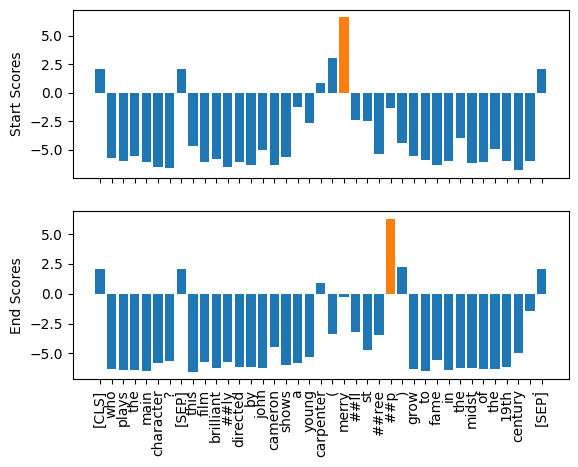

In [18]:
# refactored: visualize logits values for each token both for predicted start token and end token
qa.plot.plot_logits_as_barchart(inputs, outputs, tokenizer)

# Haystack: Retriever-Reader architecture
## Document Store

In [18]:
# launch elastic search docker container
hs.utils.launch_es()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Unable to find image 'elasticsearch:7.9.2' locally
7.9.2: Pulling from library/elasticsearch
9f74aa7d9ab9: Pulling fs layer
400a45e237b0: Pulling fs layer
da3333bd92b5: Pulling fs layer
8fcb044e3dce: Pulling fs layer
68c8ab10a68b: Pulling fs layer
f1a49ad5d099: Pulling fs layer
ce2c85c995ef: Pulling fs layer
bbfc9a234a20: Pulling fs layer
724bf09a020c: Pulling fs layer
8fcb044e3dce: Waiting
68c8ab10a68b: Waiting
f1a49ad5d099: Waiting
ce2c85c995ef: Waiting
bbfc9a234a20: Waiting
724bf09a020c: Waiting
400a45e237b0: Verifying Checksum
400a45e237b0: Download complete
8fcb044e3dce: Download complete
da3333bd92b5: Verifying Checksum
da3333bd92b5: Download complete
f1a49ad5d099: Verifying Checksum
f1a49ad5d099: Download complete
ce2c85c995ef: Verifying Checksum
ce2c85c995ef: Download complete
bbfc9a234a20: Verifying Checksum
bbfc9a234a20: Download complete
724bf09a020c: Download complete
9f74aa7d9ab9: Verifying Checksum
9f74aa7d9ab9: Download complete
9f74aa7d9ab9: Pull complete
400a45e237b0: 

cec8b1dca7c23e1e3bfa8ce5eb03998d6432a0c13312c579028bc34699635ce9


In [19]:
# verifying that elasticsearch cluster works
!curl -X GET "localhost:9200/?pretty"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
{
  "name" : "cec8b1dca7c2",
  "cluster_name" : "docker-cluster",
  "cluster_uuid" : "PaaWLd4URPq9HqODjXe-Nw",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "default",
    "build_type" : "docker",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T04:28:49.179747Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


In [22]:
!curl -X GET "localhost:9200/_cat/indices"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
yellow open movies 4ZW7kCudQja8SFzfVnGejw 1 1 0 0 208b 208b
yellow open label  9RFaY-AWRxWJIwQqspwxaw 1 1 0 0 208b 208b


**Note**: below cell has been extracted form haystack tutorial: https://haystack.deepset.ai/tutorials/01_basic_qa_pipeline

In [21]:
# Get the host where Elasticsearch is running, default to localhost
host = os.environ.get("ELASTICSEARCH_HOST", "localhost")
document_store = hs.document_stores.ElasticsearchDocumentStore(host=host, username="", password="", index=DOMAIN, return_embedding=True)

### ingest data from dfs into document store

In [83]:
# refactored
def df_row_to_ES_doc(row, split: str) -> dict:
    return {
        "content": row.context, 
        "meta": {
            "item_id": row.title, 
            "question_id": row.id,
            "split": split,
        }}


def df_to_ES_doc(df: pd.DataFrame, split: str) -> list[dict]:
    return [
        df_row_to_ES_doc(row, split) 
        for row in df.drop_duplicates(subset="context").itertuples()
        ]

for split, df in dfs.items():
    docs = df_to_ES_doc(df, split)
    document_store.write_documents(docs, index=DOMAIN)

print(f"Loaded {document_store.get_document_count():,} documents")

Loaded 1,624 documents


# Retriever

In [85]:
es_retriever = hs.nodes.BM25Retriever(document_store=document_store)

Looking at an example

In [107]:
item_id = "630575067X" # star wars episode 1
query = " who is the main character?"
retrieved_docs = es_retriever.retrieve(query=query, top_k=3, filters={"item_id": item_id, "split": "train"})
print(*retrieved_docs, sep='\n')

<Document: id=6a09e915e3af83102ab11bbc6527b4f3, content='1- Lacks a main character (no protagonist)2- Anakin is not introduced until 45 minutes into the movi...'>
<Document: id=2d0d8ad846456f58d2e68042b71e4398, content='Yes, my main gripe, like many fans of the franchise, is Jake Lloyd. But to surprise a few people, I ...'>
<Document: id=d450c78a3b8e7ae2c362299a99d5a58b, content='Get ready to be swept away by the next installment of one of the most loved and watched sci-fi movie...'>


# Reader

In [101]:
from haystack.nodes import FARMReader

# Load a  local model or any of the QA models on
# Hugging Face's model hub (https://huggingface.co/models)

MAX_SEQ_LENGTH, DOC_STRIDE = 384, 128

reader = FARMReader(model_name_or_path=READER_MODEL, 
    use_gpu=True, 
    progress_bar=False, 
    max_seq_len=MAX_SEQ_LENGTH,
    doc_stride=DOC_STRIDE,
    return_no_answer=True)


In [102]:
print(reader.predict_on_texts(question=question, texts=[context], top_k=1))

{'query': 'Who plays the main character?', 'no_ans_gap': 8.695183277130127, 'answers': [<Answer {'answer': 'Merryll Streep', 'type': 'extractive', 'score': 0.9352176189422607, 'context': 'this film brilliantly directed by John Cameron shows a young carpenter (Merryll Streep) grow to fame in the midst of the 19th century.', 'offsets_in_document': [{'start': 72, 'end': 86}], 'offsets_in_context': [{'start': 72, 'end': 86}], 'document_id': '9862efcec7c7cc3e2135f7fa86ee6601', 'meta': {}}>]}


## Pipeline

In [103]:
pipe = hs.pipelines.ExtractiveQAPipeline(reader, es_retriever)



In [114]:
TOP_K_READER = 3

item_id = "630575067X" # star wars episode 1
query = " how long is this movie?"

params = {
    "Retriever": {
        "top_k": 3,
        "filters": {
            "item_id": [item_id],
            "split": "train",
            }
        },
    "Reader": {
        "top_k": TOP_K_READER,
        },
    }
preds = pipe.run(query=query, params=params)

print(f"Question: {preds['query']}\n")
for idx in range(TOP_K_READER):
    print(f"Answer {idx + 1}: {preds['answers'][idx].answer}")
    print(f"Review snippet: ...{preds['answers'][idx].context}...\n\n")



Question:  how long is this movie?

Answer 1: 16 years
Review snipper: ...hey want; I just feel that they're judging The Phantom Menace based on 16 years of their own expectations rather than judging it for what it is: a vis...


Answer 2: 
Review snipper: ...None...


Answer 3: a huge disapointment
Review snipper: ...t this film would equal the Second Coming. However, the movie is a huge disapointment. Granted, the special effects  and ship and creature designs are...




# Improving QA Pipeline
## Evaluating Retriever

In [115]:
pipe = hs.pipelines.DocumentSearchPipeline(retriever=es_retriever)

### Generating labeled data for pipeline evaluation for test set

In [149]:
# refactored
labels = qa.label.create_labels_from_df(dfs["test"])

document_store.write_labels(labels, index="label")

print(f"""Loaded {document_store.get_label_count(index="label")} \
question-answer pairs""")

Loaded 337 question-answer pairs


In [150]:
labels_agg = document_store.get_all_labels_aggregated(
    index="label",
    open_domain=True,
    aggregate_by_meta=["item_id"]
)
print(len(labels_agg))

273


In [291]:
labels_agg[0]

<MultiLabel: {'labels': [<Label: {'id': '8ef3bfc1-2164-4084-91c2-de61ff0d5049', 'query': 'What is your take on the direction the movie is taking?', 'document': {'id': 'e55d379edfcd04ec185b78106ecdb173', 'content': "This was in my opinion not a movie but an experience. Mel Gibson did such a great job of potraying the last hours of our Lord and Savior Jesus Christ's life. The movie was so moving and touching. I can't imagine having any of that done to me. Unfortunately, Jesus really didn't have a choice. That was foretold to happen to Jesus so we could be washed clean from our sins and have everlasting life.And to those who think that this movie was unrealistic in some respects you're right. It wasn't entirely realistc...because Jesus looked even worse then what they showed. In the Bible it clearly states that you couldn't even recognize Jesus that was how badly beaten he was.But, as to why no one helped him when he was being beaten or why he let them arrest him it was because it was for

In [160]:
# We can run the pipeline with the desired top_k value like this
eval_result = pipe.eval(
    labels=labels_agg,
    params={"Retriever": {"top_k": 3}},
)
metrics = eval_result.calculate_metrics()

print(f"Recall@3: {metrics['Retriever']['recall_single_hit']:.2f}")

Recall@3: 0.98


In [163]:
eval_result["Retriever"].head(3)

,multilabel_id,query,filters,context,gold_contexts,gold_id_match,context_match,answer_match,gold_id_or_answer_match,gold_id_and_answer_match,...,rank,document_id,gold_document_ids,gold_documents_id_match,gold_contexts_similarity,gold_answers_match,type,node,eval_mode,index
0,a3ecbb85a1f7497a9180023ca4656c5d,What is your take on the direction the movie is taking?,"b'{""item_id"": [""0310263662""], ""split"": [""test""]}'","I find it sad that reviewers such as ""A Kid's Review"" (only one of quite a f...",[],0.0,0.0,0.0,0.0,0.0,...,1.0,b964217f3614e4b573c7c1e058cc3032,[],[],[],[0.0],document,Retriever,integrated,0
1,a3ecbb85a1f7497a9180023ca4656c5d,What is your take on the direction the movie is taking?,"b'{""item_id"": [""0310263662""], ""split"": [""test""]}'","Now I am not a religious person, even tough I believe in the existence of a ...",[],0.0,0.0,0.0,0.0,0.0,...,2.0,45b427836e490b1e008e15b8c84560ab,[],[],[],[0.0],document,Retriever,integrated,1
2,a3ecbb85a1f7497a9180023ca4656c5d,What is your take on the direction the movie is taking?,"b'{""item_id"": [""0310263662""], ""split"": [""test""]}'",This was in my opinion not a movie but an experience. Mel Gibson did such a ...,[],0.0,0.0,0.0,0.0,0.0,...,3.0,be832bea3625db1ba345826e781f6916,[],[],[],[0.0],document,Retriever,integrated,2


In [174]:
retriever_results = {}

retriever_results["bm25"] = qa.evaluate.retriever_recall(es_retriever)


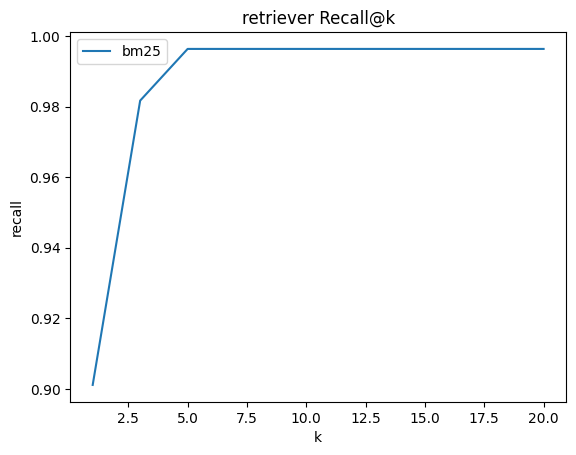

In [178]:
# refactored
qa.plot.plot_retriever_eval(retriever_results)

## Comparing with DPR retriever

In [179]:
dpr_retriever = hs.nodes.DensePassageRetriever(
    document_store=document_store,
    query_embedding_model=DPR_QUERY_MODEL,
    passage_embedding_model=DPR_CTX_ENCODER,
    embed_title=False)

Downloading: 100%|██████████| 28.0/28.0 [00:00<00:00, 12.6kB/s]
Downloading: 100%|██████████| 232k/232k [00:00<00:00, 587kB/s] 
Downloading: 100%|██████████| 466k/466k [00:00<00:00, 962kB/s] 
Downloading: 100%|██████████| 493/493 [00:00<00:00, 161kB/s]
Downloading: 100%|██████████| 438M/438M [01:28<00:00, 4.93MB/s] 
Downloading: 100%|██████████| 28.0/28.0 [00:00<00:00, 9.15kB/s]
Downloading: 100%|██████████| 232k/232k [00:00<00:00, 863kB/s] 
Downloading: 100%|██████████| 466k/466k [00:00<00:00, 953kB/s] 
Downloading: 100%|██████████| 492/492 [00:00<00:00, 218kB/s]
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokenizerFast'.
Downloading: 100%|██████████| 438M/438M [01:05<00:00, 6.70MB/s] 


In [180]:
document_store.update_embeddings(retriever=dpr_retriever)

Updating embeddings: 10000 Docs [02:04, 80.44 Docs/s]           


In [316]:
# looking at doc structure after adding embeddings:
id = "6c00f4d6afc79231d114fe34b9c6217b"
doc = document_store.get_document_by_id(id)
display(doc)
print(f"embedding type: {type(doc.embedding)}")

<Document: {'content': "Okay, I was just like everyone else--I wanted to see this movie really really badly.  So I did.  And at first I thought it was great!  But later, I realized how very childish this movie is.  Sure, the visual effects were nice, and the pod race was cool, but the visuals can't compare with The Matrix.  Also, Jar Jar Binks and Boss Nass are a very unwelcome addition, with their very eyeball-rolling senses of humor.  And the plot wasn't very clever either.  It's really pretty hard to relate this movie to the Trilogy.  If you're anyone under 13 (as I was when I saw it), you should like at the very least like it, as long as you don't expect it to be like the old Star Wars.  But if you are an adult who is a big fan of the Trilogy, avoid The Phantom Menace at all costs.Rated PG, for sci-fi action and violence, not much else, really everyone should be allowed to see it.  But the question remains: does EVERYONE really WANT TO?", 'content_type': 'text', 'score': 0.53120937

embedding type: <class 'numpy.ndarray'>


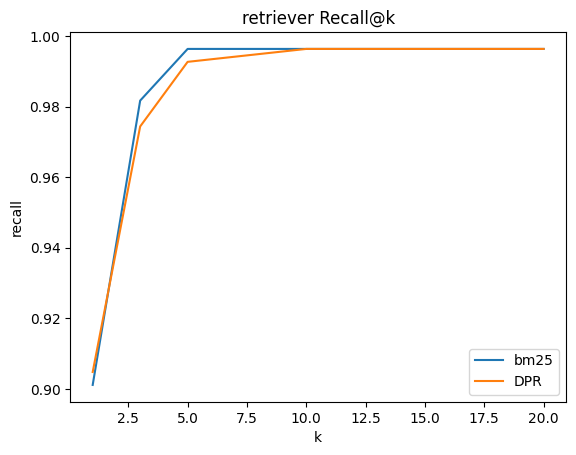

In [181]:
retriever_results["DPR"] = qa.evaluate.retriever_recall(dpr_retriever)

qa.plot.plot_retriever_eval(retriever_results)

# TO DO: fine tuning DPR on dataset
https://haystack.deepset.ai/tutorials/09_dpr_training

## Evaluating Reader

In [184]:
# refactored
def print_reading_metrics(pred, label) -> None:
    print(f"label:      {label}")
    print(f"prediction: {pred}")
    print(f"\tEM: {compute_exact(label, pred)}")
    print(f"\tF1: {compute_f1(label, pred)}")

print_reading_metrics(pred = "about 6000 hours", label = "6000 hours")
print_reading_metrics(f"about 6000 dollars", "6000 hours")

label:      6000 hours
prediction: about 6000 hours
	EM: 0
	F1: 0.8
label:      6000 hours
prediction: about 6000 dollars
	EM: 0
	F1: 0.4


In [187]:
# refactored
reader_eval = {}
reader_eval["MiniLM. Fine-tuned on SQUAD"] = qa.evaluate.evaluate_reader(reader)

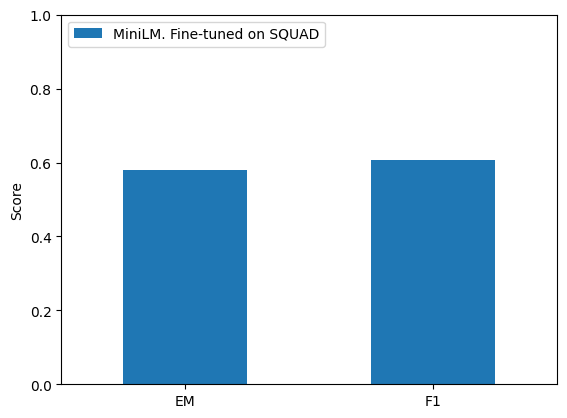

In [189]:
# refactored
qa.plot.plot_reader_eval(reader_eval)

## Domain Adaptation
Requires to transform training data into SQUAD JSON format

In [258]:
# refactored
qa.squad_conversion.convert_all_data_to_squad_format(dfs, TRANSFORMED_DATA_DIR + SQUAD_FILENAME_TEMPLATE)

In [ ]:
# /!\ takes ~21min per epoch to train on an M1.
reader.train(
    data_dir=TRANSFORMED_DATA_DIR,
    use_gpu=True,
    n_epochs=1,
    batch_size=16,
    train_filename=SQUAD_FILENAME_TEMPLATE.format(split="train"),
    dev_filename=SQUAD_FILENAME_TEMPLATE.format(split="validation"),
)

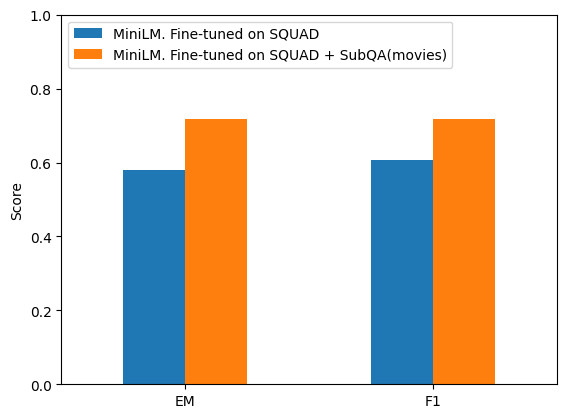

In [263]:
reader_eval["MiniLM. Fine-tuned on SQUAD + SubQA(movies)"] = qa.evaluate.evaluate_reader(reader)
plot_reader_eval(reader_eval)

## Comparing with model fine-tuned without SQUAD transfer learning 

In [295]:
MINILM_CKPT = "microsoft/MiniLM-L12-H384-uncased"
minilm_reader = hs.nodes.FARMReader(
    model_name_or_path=MINILM_CKPT, 
    progress_bar=False, 
    max_seq_len=MAX_SEQ_LENGTH, 
    doc_stride=DOC_STRIDE, 
    return_no_answer=True,
)

Downloading: 100%|██████████| 385/385 [00:00<00:00, 231kB/s]
Downloading: 100%|██████████| 133M/133M [00:17<00:00, 7.58MB/s] 
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Downloading: 100%|██████████| 2.00/2.00 [00:00<00:00, 972B/s]
Downloading: 100%|██████████| 232k/232k [00:00<00:00, 588kB/s] 
Downloading: 100%|██████████| 112/112 [00:00<00:00, 95.5kB/s]


In [296]:
minilm_reader.train(
    data_dir="../data/transformed/",
    use_gpu=True,
    train_filename=SQUAD_FILENAME_TEMPLATE.format(split="train"), 
    dev_filename=SQUAD_FILENAME_TEMPLATE.format(split="validation"),
    n_epochs=1,
    batch_size=16,
)

Preprocessing dataset:   0%|          | 0/3 [00:00<?, ? Dicts/s]WARNING:haystack.modeling.data_handler.processor:Answer 'made you who you are, and you use it to bleed even more and more money out of us.Palpatine would have been proud. ANSWERNOTFOUND' not contained in context.
Example will not be converted for training/evaluation.
Example will not be converted for training/evaluation.
Example will not be converted for training/evaluation.
Preprocessing dataset:  33%|███▎      | 1/3 [00:00<00:01,  1.39 Dicts/s]WARNING:haystack.modeling.data_handler.processor:Answer 'The music, including the new song, is still outstanding.So what's my complaint?  It's the same one I have with the stage version.  The Phantom is made out to be sympathetic.  This is even truer here as we see his past as a little boy.  The problem is he's an evil man whose true nature comes out the more people stand up to him.  I realize I'm alone in not enjoying this glorification.  At least he does realize how bad his behav

In [297]:
reader_eval[f"MiniLM. Fine-tuned on subjqa({DOMAIN}"] = qa.evaluate.evaluate_reader(minilm_reader)

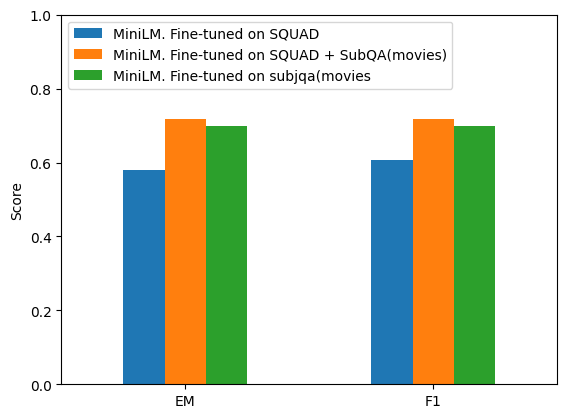

In [298]:
qa.plot.plot_reader_eval(reader_eval)